*This notebook explores the results of the "Generative Discovery" experiments with the proper parameterization.*

# Imports

## Libraries

In [18]:
import os
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [19]:
from orbit_generation.constants import EM_MU
from orbit_generation.processing import reorder_orbits
from orbit_generation.propagation import jacobi_constant
from orbit_generation.visualize import plot_histogram, visualize_static_orbits
from orbit_generation.experiment import read_json_to_dataframe, generate_image_paths, concatenate_csvs_from_experiment_folder
from orbit_generation.latent_space import plot_combined_2d_latent_space, plot_2d_latent_space
from orbit_generation.dataset import get_first_period_dataset

## Data

In [20]:
experiments_folder = r'../../experiments'
experiments_file = r'../../experiments/experiments.json'
results_folder = r'../../experiments/results'
generated_orbits_path = os.path.join(results_folder, 'generated_orbits')
refined_orbits_path = os.path.join(results_folder, 'refined_orbits')
latent_space_with_distributions_path = os.path.join(results_folder, 'latent_space_label_distribution')
metrics_corr_matrix_path = os.path.join(results_folder, 'metrics_corr_matrix')

In [21]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
data, orbit_df, _, _ = get_first_period_dataset(file_path=data_path)

In [66]:
df=read_json_to_dataframe(experiments_file)
df.shape

(193, 31)

In [67]:
generation_df = concatenate_csvs_from_experiment_folder(experiments_folder,'generation_df')
generation_df.shape

(55200, 10)

In [68]:
refined_orbits_df = concatenate_csvs_from_experiment_folder(experiments_folder,'refined_orbits_df')
refined_orbits_df = refined_orbits_df.dropna(axis=0)
refined_orbits_df.shape

(19954, 44)

# Processing

In [69]:
# Add the parameters as columns
parameters_df = df['parameters'].apply(pd.Series)
df = pd.concat([df, parameters_df], axis=1)
df = df.drop(columns=['parameters'])

# Extract only the 'beta' parameter from model_kwargs
beta_values = df['model_kwargs'].apply(lambda x: x.get('beta'))
df['beta'] = beta_values
df = df.drop(columns=['model_kwargs'])

In [70]:
# KL-loss was being multiplied by beta, so a few adjustments are needed
df['train_kl_loss'] = df['train_kl_loss'] / df['beta']
df['val_kl_loss'] = df['val_kl_loss'] / df['beta']

## Filtering

In [71]:
# Take just the experiments of Generative Discovery
df = df[(df['id'] >= 1) & (df['id'] <= 140)]
generation_df['experiment_id'] = generation_df['experiment_id'].astype(int)
generation_df = generation_df[(generation_df['experiment_id'] >= 1) & (generation_df['experiment_id'] <= 140)]
refined_orbits_df['experiment_id'] = refined_orbits_df['experiment_id'].astype(int)
refined_orbits_df = refined_orbits_df[(refined_orbits_df['experiment_id'] >= 1) & (refined_orbits_df['experiment_id'] <= 140)]
refined_orbits_df.shape

(15419, 44)

In [72]:
len(refined_orbits_df['experiment_id'].value_counts())

140

As can be seen afterwards, experiments with beta=10 tend to mode collpase that's why we filter them

In [73]:
filter_beta_10=False

In [74]:
init_df=df

In [75]:
if filter_beta_10:
    rows_to_remove = df[df['beta'] == float(10)]
    distinct_ids = rows_to_remove['id'].unique()
    distinct_ids = [int(x) for x in distinct_ids]
    print(df.shape)
    df = df[df['beta'] != float(10)]
    print(df.shape)
    
    print("Before filtering:", generation_df.shape)
    generation_df = generation_df[~generation_df['experiment_id'].isin(distinct_ids)]
    print("After filtering:", generation_df.shape)

    print(refined_orbits_df.shape)
    refined_orbits_df = refined_orbits_df[~refined_orbits_df['experiment_id'].isin(distinct_ids)]
    print(refined_orbits_df.shape)

In [76]:
# Add refined Orbits to experiment df
experiment_id_counts = refined_orbits_df['experiment_id'].value_counts()
experiment_id_counts.index = experiment_id_counts.index.astype(df['id'].dtype)

df = df.merge(experiment_id_counts.rename('count_refined_orbits'), 
              left_on='id', 
              right_index=True, 
              how='left')

df['count_refined_orbits'] = df['count_refined_orbits'].fillna(0).astype(int)

In [77]:
static_parameters = ['id_experiment', 'seq_len','feature_dim', 'val_split', 'batch_size', 'lr', 'epochs', 'input_seq_len_convergence', 'samples_to_generate', 'max_iter_convergence']
repeated_metrics = ['family_ari', 'family_nmi', 'family_homogeneity', 'family_completeness', 'family_fmi', 'family_purity', 'family_silhouette_score', 'family_jaccard', 'inversions', 'kendall_tau_distance']
df = df.drop(columns=static_parameters + repeated_metrics)

# Discovery
by Distance

In [78]:
refined_orbits_df = refined_orbits_df.merge(df[['id', 'discarded_family_ids']], 
                                            how='left', 
                                            left_on='experiment_id', 
                                            right_on='id')

In [79]:
refined_orbits_df.head()

,id_x,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,disorder_metric,correct_order,inversions,kendall_tau_distance,propagated_position_error,propagated_velocity_error,propagated_energy_error,latent_distance_to_generation,calculated_jacobi,period_distance_with_generation,feature_closest_orbit,feature_distance_from_closest_orbit,nearest_orbit,nearest_orbit_distance,distance_from_generation,centroid_distance,feature_centroid_distance,closest_family_centroid,closest_family_centroid_distance,closest_family_feature_centroid,closest_family_feature_centroid_distance,initial_conditions_distance,closest_family_full_centroid,closest_family_full_centroid_distance,family_of_feature_closest_orbit,family_of_closest_orbit,experiment_id,id_y,discarded_family_ids
0,0,2.825363,3.395283,9,2.866915e-13,1.085847,0.005968,-0.006422,0.007797,0.193831,-0.008355,1.131194,-0.024008,2.689891e-16,-0.007002,0.117360,-2.899136e-15,372.0,66.0,255.0,0.103030,1.329037e-12,2.465352e-12,1.481195e-14,0.116331,3.173176,0.569921,17972,0.000104,17976,0.409855,1.208203,0.830977,3.933960,22,0.166260,6,0.645355,0.095566,6,0.121419,15.0,15.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]"
1,3,6.410875,6.306637,9,3.831047e-10,1.077167,0.244604,0.427690,0.050803,-1.548356,0.846692,0.774984,0.387647,4.910636e-01,0.073323,-1.206546,8.439762e-01,150.0,69.0,98.0,0.039596,6.852558e-12,1.434101e-11,2.466171e-11,0.239348,0.591147,0.104238,30631,0.000694,27453,3.967637,4.725327,2.500625,2.045136,18,0.486709,15,0.159043,0.482846,23,0.482840,29.0,25.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]"
2,5,2.774760,3.382448,8,1.560247e-13,1.078207,0.011581,0.003735,0.007048,0.144430,-0.018307,1.140318,-0.014000,-7.494117e-14,-0.005923,0.077325,1.243685e-13,276.0,64.0,187.0,0.075556,1.162738e-12,2.025713e-12,3.925031e-15,0.140431,3.179420,0.607688,17992,0.000240,17992,0.169285,1.082909,0.824064,3.947770,22,0.173278,6,0.659336,0.097635,6,0.114895,15.0,15.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]"
3,11,22.927443,22.944445,9,6.897051e-12,1.048586,0.020412,-0.036356,0.013088,0.715763,-0.018567,0.906908,0.048871,-1.470502e-02,0.185644,0.562421,2.131846e-02,4.0,98.0,2.0,0.000808,7.630890e-12,1.316706e-11,2.564077e-12,0.045951,2.885993,0.017003,42943,0.003184,42922,2.087514,2.232660,1.988188,15.698535,32,0.302875,37,1.264695,0.276101,37,0.300966,40.0,40.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]"
4,14,6.659652,5.645048,6,3.873477e-12,0.787035,-0.122416,0.049502,0.276159,0.940814,-0.412493,0.642761,-0.185012,1.920668e-02,0.314235,0.605758,-3.829873e-01,68.0,78.0,36.0,0.014545,1.742954e-12,3.321685e-12,1.132078e-12,0.263792,2.810963,1.014603,28414,0.000941,28420,0.970354,2.066139,0.323756,1.658958,19,0.222946,14,0.327624,0.374478,24,0.221195,26.0,26.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]"


In [80]:
def check_discovered(row):
    """
    Checks if a family is discovered based on feature distance or physical distance.

    Args:
        row (pd.Series): A row of the DataFrame containing the required columns.

    Returns:
        str: 'no', 'yes_by_feature_distance', or 'yes_by_physical_distance'.
    """
    discarded_ids = row['discarded_family_ids']
    
    if row['family_of_feature_closest_orbit'] in discarded_ids:
        return 'yes_by_feature_distance'
    elif row['family_of_closest_orbit'] in discarded_ids:
        return 'yes_by_physical_distance'
    else:
        return 'no'

# Apply the function to create a new column
refined_orbits_df['is_discovered'] = refined_orbits_df.apply(check_discovered, axis=1)

In [81]:
# Filter the DataFrame for is_discovered = True
discovery_df = refined_orbits_df[refined_orbits_df['is_discovered'] != 'no']

# Count distinct values in both columns
family_of_feature_closest_orbit_unique = discovery_df['family_of_feature_closest_orbit'].nunique()
family_of_closest_orbit_unique = discovery_df['family_of_closest_orbit'].nunique()

# Results
print(f"Distinct values in family_of_feature_closest_orbit: {family_of_feature_closest_orbit_unique}")
print(f"Distinct values in family_of_closest_orbit: {family_of_closest_orbit_unique}")

Distinct values in family_of_feature_closest_orbit: 39
Distinct values in family_of_closest_orbit: 36


Check Discovery Table is correct:

In [82]:
discovery_df[['family_of_feature_closest_orbit','family_of_closest_orbit', 'discarded_family_ids']].tail()

,family_of_feature_closest_orbit,family_of_closest_orbit,discarded_family_ids
15383,4.0,6.0,"[19.0, 22.0, 6.0, 4.0, 34.0]"
15412,42.0,34.0,"[19.0, 22.0, 6.0, 4.0, 34.0]"
15413,34.0,34.0,"[19.0, 22.0, 6.0, 4.0, 34.0]"
15414,34.0,34.0,"[19.0, 22.0, 6.0, 4.0, 34.0]"
15418,40.0,34.0,"[19.0, 22.0, 6.0, 4.0, 34.0]"


In [83]:
discovery_df.head()

,id_x,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,disorder_metric,correct_order,inversions,kendall_tau_distance,propagated_position_error,propagated_velocity_error,propagated_energy_error,latent_distance_to_generation,calculated_jacobi,period_distance_with_generation,feature_closest_orbit,feature_distance_from_closest_orbit,nearest_orbit,nearest_orbit_distance,distance_from_generation,centroid_distance,feature_centroid_distance,closest_family_centroid,closest_family_centroid_distance,closest_family_feature_centroid,closest_family_feature_centroid_distance,initial_conditions_distance,closest_family_full_centroid,closest_family_full_centroid_distance,family_of_feature_closest_orbit,family_of_closest_orbit,experiment_id,id_y,discarded_family_ids,is_discovered
9,21,4.109756,3.772282,11,5.809167e-10,-0.492125,0.017246,0.879876,0.044311,1.155262,0.058201,-1.305611,-0.148333,3.786156e-12,-0.247352,2.178455,-3.109613e-11,546.0,58.0,363.0,0.146667,1.039431e-11,1.529578e-11,8.716139e-11,1.916160,-1.540141,0.337474,8364,1.863932,22356,14.585988,17.799465,1.352006,5.260581,14,0.793401,26,3.123184,1.612060,19,0.614075,8.0,20.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",yes_by_physical_distance
41,105,3.786636,2.695289,8,4.236947e-12,0.901330,0.027432,0.031192,-0.054651,0.094691,0.007353,0.835528,-0.013808,-3.159178e-13,-0.009413,0.014662,9.915588e-13,782.0,68.0,540.0,0.218182,1.157259e-12,2.640594e-12,3.033264e-14,0.135950,3.199292,1.091347,11652,0.000043,11679,0.279380,1.331631,0.969881,4.626887,22,0.025567,27,0.021343,0.124534,27,0.026574,10.0,10.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",yes_by_feature_distance
43,110,5.809158,2.906221,10,1.646301e-10,0.763687,0.108018,0.001552,-0.004107,0.325480,0.014488,0.831495,0.086320,-1.181488e-14,0.077371,0.146500,-2.768109e-14,518.0,63.0,341.0,0.137778,1.625316e-12,6.635515e-12,2.152151e-12,0.668609,3.149150,2.902937,11511,0.000887,11540,1.099301,2.544065,0.943858,4.410495,22,0.051885,27,0.204942,0.209651,27,0.052892,10.0,10.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",yes_by_feature_distance
44,111,3.620637,2.960255,8,3.314262e-10,0.732160,0.038682,0.011956,-0.009810,0.477991,-0.004243,0.811601,-0.017497,5.036500e-14,-0.017670,0.258789,2.833329e-13,296.0,63.0,195.0,0.078788,2.090426e-12,1.005065e-11,3.576775e-12,0.107120,3.138802,0.660381,11496,0.000411,11511,0.846723,1.856263,0.890234,4.355490,22,0.106171,27,0.259924,0.240290,27,0.107178,10.0,10.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",yes_by_feature_distance
47,114,6.198089,3.173515,10,4.280202e-12,-0.384599,0.032056,0.016298,-0.070312,3.027065,0.028812,-0.828224,0.608296,-1.896491e-15,1.191312,1.560566,-1.250985e-14,264.0,64.0,167.0,0.067475,7.291419e-13,4.948208e-12,2.897974e-13,0.702469,-0.832852,3.024574,8364,1.041229,22485,12.339714,11.756360,1.299619,5.207866,4,0.643684,7,2.886682,2.066945,4,0.640804,8.0,20.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",yes_by_physical_distance


Experiments with more families discovered

In [84]:
distinct_counts = discovery_df.groupby('experiment_id')['family_of_closest_orbit'].nunique().sort_values(ascending=False)
print(distinct_counts)

experiment_id
107    16
109    14
85     14
92     14
114    14
100    13
137    13
136    13
71     12
132    12
127    12
123    12
134    12
135    11
139    11
120    11
104    11
115    10
78     10
99     10
101    10
93     10
86     10
129    10
124     9
106     9
80      9
117     9
116     9
67      9
138     9
126     9
79      9
57      9
64      9
65      9
97      8
52      8
58      8
121     8
113     8
131     8
128     8
81      8
108     8
102     8
96      7
94      7
68      7
29      7
72      7
74      7
122     7
82      7
110     7
63      6
44      6
88      6
91      6
83      6
87      6
130     6
118     6
112     6
111     6
95      6
103     6
76      6
73      6
43      5
59      5
47      5
60      5
39      5
41      5
37      5
36      5
119     5
125     5
90      5
89      5
46      5
61      4
70      4
69      4
66      4
31      4
133     4
98      4
140     4
51      4
45      4
62      3
30      3
77      3
105     3
33      3
32      2
40    

In [85]:
sorted_ids = distinct_counts.index
sorted_df = df.set_index('id').loc[sorted_ids].reset_index()
sorted_df.head()

,experiment_id,discarded_family_ids,discarded_families,val_total_loss,val_reconstruction_loss,val_kl_loss,train_total_loss,train_reconstruction_loss,train_kl_loss,family_v-measure,family_accuracy,position_error,velocity_error,energy_error,disorder_metric,correct_order,regression_jacobi_r2,regression_period_r2,regression_stability_r2,data_used,families_to_discard,model_name,latent_dim,distance_metric,beta,count_refined_orbits
0,107,"[37.0, 26.0, 30.0, 10.0, 36.0, 5.0, 21.0, 24.0...","[S_R23, S_L5_A, S_LPOE, S_L1_L, S_R21, S_DRO, ...",2.086706,0.765441,6.606330,2.463329,0.992290,7.355188,0.85483,0.749857,0.161440,0.339817,1.741626,258.906667,66.736667,0.214653,0.830198,0.078059,EM_N_fix_1500,20,inception_time_wp_vae,6,euclidean,0.200,129
1,109,"[11.0, 18.0, 30.0, 17.0, 24.0, 35.0, 3.0, 12.0...","[S_L1_V, S_L3_HN, S_LPOE, S_L3_A, S_L4_SP, S_R...",6.583935,1.517367,5.066568,6.788245,1.751801,5.036442,0.868537,0.782733,0.096514,0.273590,2.817960,162.726667,70.490000,0.639710,0.711977,0.145525,EM_N_fix_1500,20,inception_time_wp_vae,6,euclidean,1.000,164
2,85,"[38.0, 7.0, 11.0, 8.0, 19.0, 4.0, 25.0, 13.0, ...","[S_R31, S_L1_A, S_L1_V, S_L1_HN, S_L3_HS, S_DP...",2.393264,2.358850,34.414206,2.074154,2.037747,36.407851,0.738964,0.54319,0.247000,0.435030,1.121503,391.880000,70.416667,0.160402,0.704023,0.081999,EM_N_fix_1500,20,vae_conv5_legit,2,euclidean,0.001,126
3,92,"[1.0, 9.0, 39.0, 22.0, 35.0, 8.0, 30.0, 32.0, ...","[S_BN, S_L1_HS, S_R32, S_L4_A, S_R14, S_L1_HN,...",0.327536,0.309597,17.939543,0.496893,0.476555,20.337773,0.798784,0.629027,0.182796,0.336668,1.447032,281.106667,76.776667,0.347808,0.676703,0.120085,EM_N_fix_1500,20,vae_conv5_legit,6,euclidean,0.001,93
4,114,"[28.0, 42.0, 9.0, 33.0, 17.0, 38.0, 16.0, 30.0...","[S_L5_SP, S_R43, S_L1_HS, S_R12, S_L3_A, S_R31...",1.791177,0.762435,5.143707,2.090796,1.007295,5.417504,0.849191,0.742792,0.271843,0.364542,0.457431,269.853333,73.763333,0.215633,0.627119,0.018027,EM_N_fix_1500,30,vae_conv5_legit,2,euclidean,0.200,146


In [86]:
count_physical_distance = refined_orbits_df['is_discovered'].value_counts().get('yes_by_physical_distance', 0)
count_feature_distance = refined_orbits_df['is_discovered'].value_counts().get('yes_by_feature_distance', 0)
print(f"{len(discovery_df)} orbits, out of the {len(refined_orbits_df)} refined ones, were closer to an orbit that was not included in the training:")
print(f"- {count_physical_distance} by physical distance, in which you can find {family_of_feature_closest_orbit_unique} families out of the total 42")
print(f"- {count_feature_distance} by feature distance, in which you can find {family_of_closest_orbit_unique} families out of the total 42")

2984 orbits, out of the 15419 refined ones, were closer to an orbit that was not included in the training:
- 388 by physical distance, in which you can find 39 families out of the total 42
- 2596 by feature distance, in which you can find 36 families out of the total 42


In [87]:
print(f"How many of the {len(refined_orbits_df)} physical orbits that were generated could be part of families we yet don't know?")

How many of the 15419 physical orbits that were generated could be part of families we yet don't know?


Some of them are really far away from the orbits from the dataset:
- In physical space:

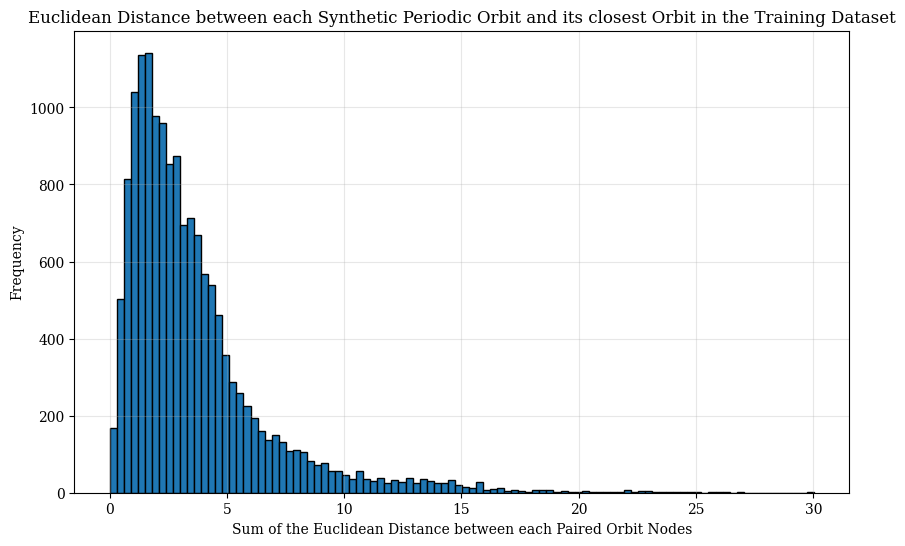

In [88]:
plot_histogram(refined_orbits_df['nearest_orbit_distance'], bins=100, title='Euclidean Distance between each Synthetic Periodic Orbit and its closest Orbit in the Training Dataset', xlabel='Sum of the Euclidean Distance between each Paired Orbit Nodes')

- In feature space:

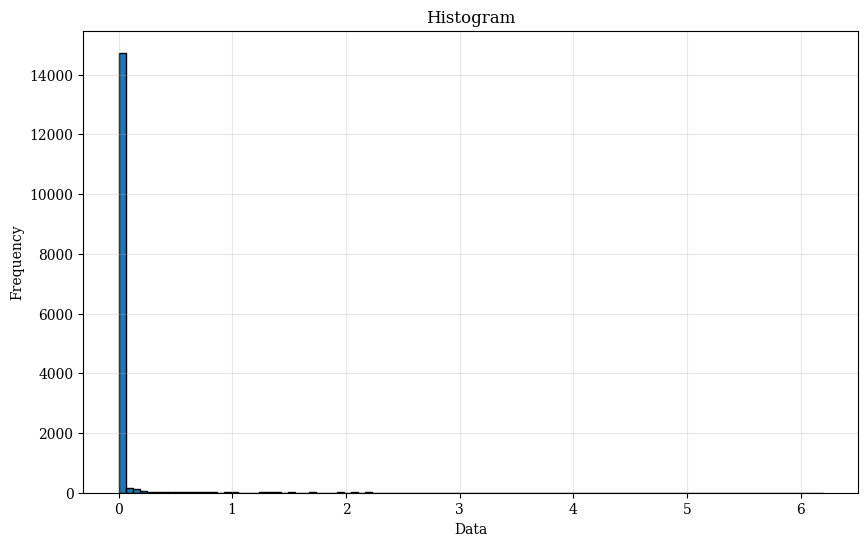

In [89]:
plot_histogram(refined_orbits_df['feature_distance_from_closest_orbit'], bins=100)

In [90]:
results = np.array([jacobi_constant(np.transpose(data[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(orbit_df.shape[0])])
orbit_df['calculated_jacobi'] = results

features_used = ['period', 'calculated_jacobi']

dataset_features = orbit_df[features_used].values
refined_orbits_features = refined_orbits_df[features_used].values

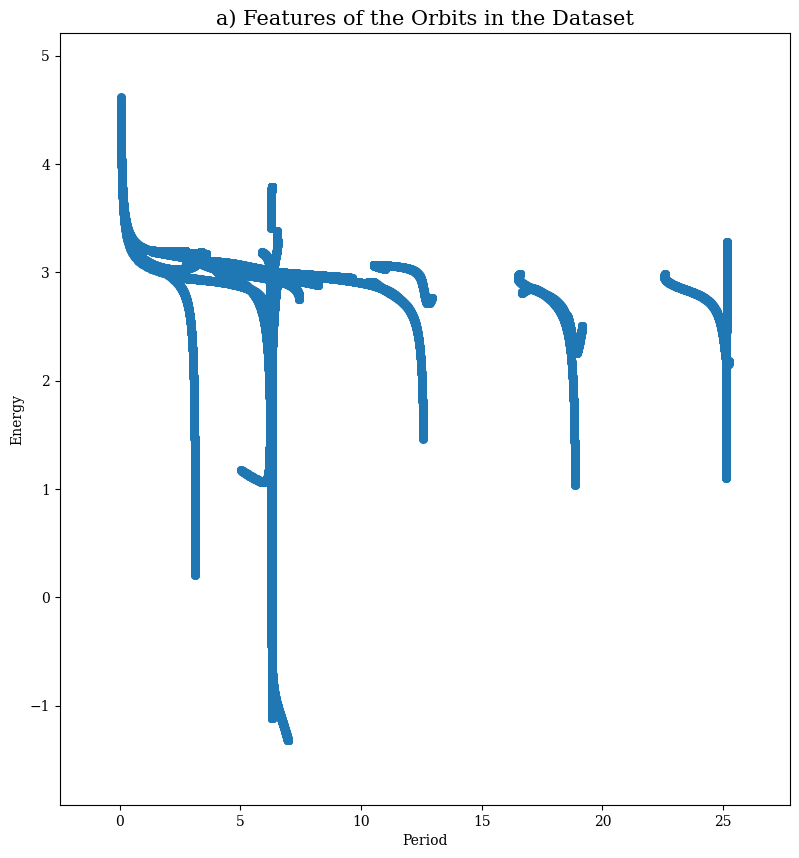

In [91]:
plot_2d_latent_space(dataset_features,
                     np.zeros(len(dataset_features)),
                     show_legend=False,
                     title='a) Features of the Orbits in the Dataset',
                     normalize_data=False,
                     figsize=(13,13.83),
                     axis_labels=('Period', 'Energy'),
                     title_size=15)

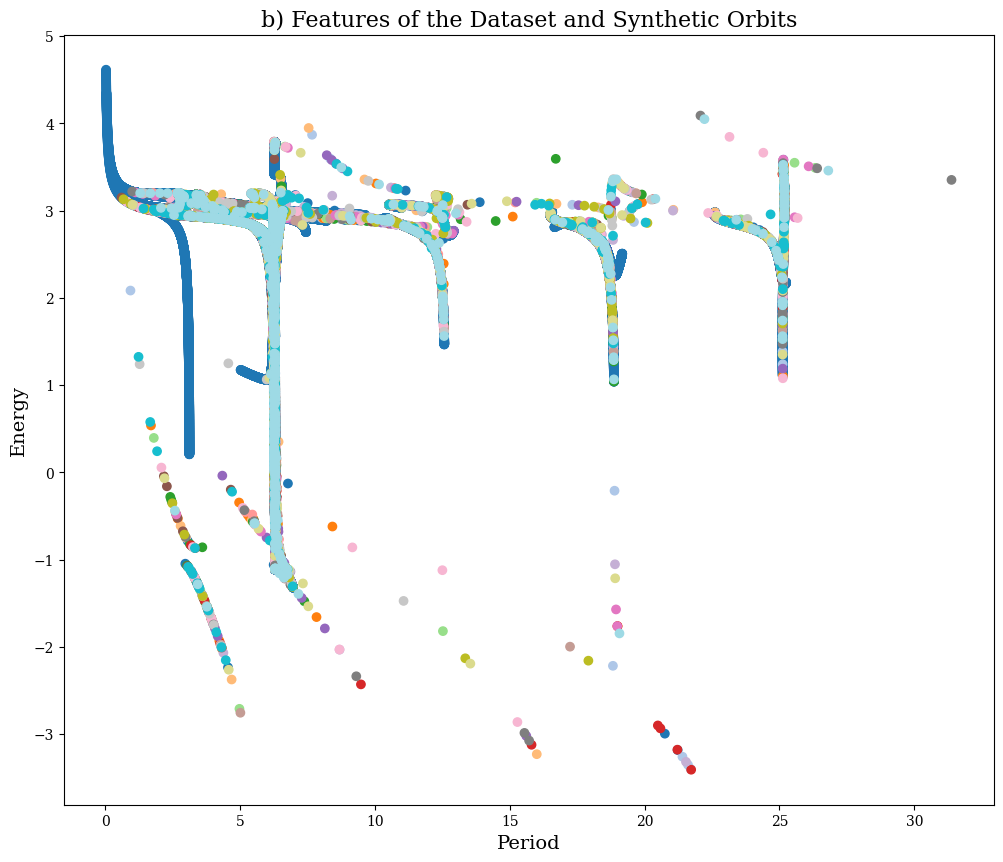

In [92]:
plot_combined_2d_latent_space(dataset_features,
                              refined_orbits_features,
                              synthetic_labels=list(range(0, len(refined_orbits_df))),
                              annotation_mode='legend',
                              show_legend=False,
                              axis_labels=('Period', 'Energy'),
                              figsize=(12,10),
                              title='b) Features of the Dataset and Synthetic Orbits',
                              
                              )

## Histograms

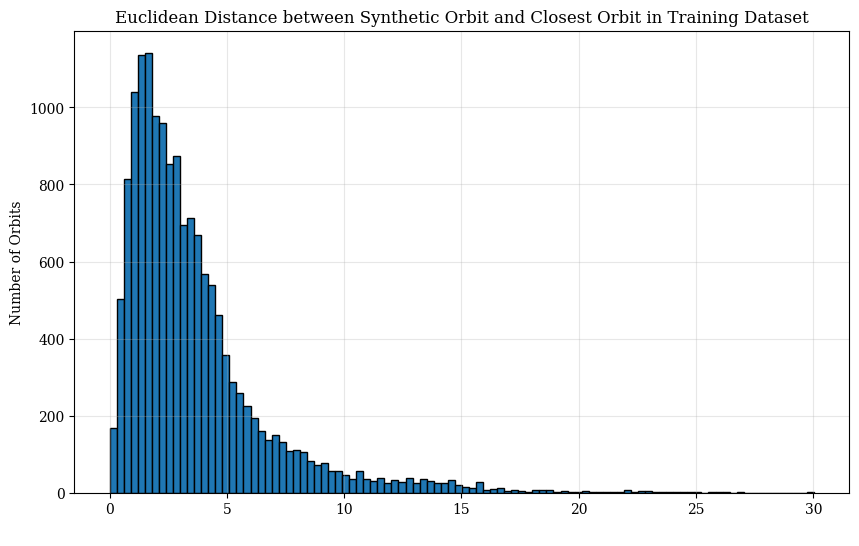

In [93]:
plot_histogram(refined_orbits_df['nearest_orbit_distance'], bins=100, title="Euclidean Distance between Synthetic Orbit and Closest Orbit in Training Dataset", ylabel='Number of Orbits', xlabel=' ')

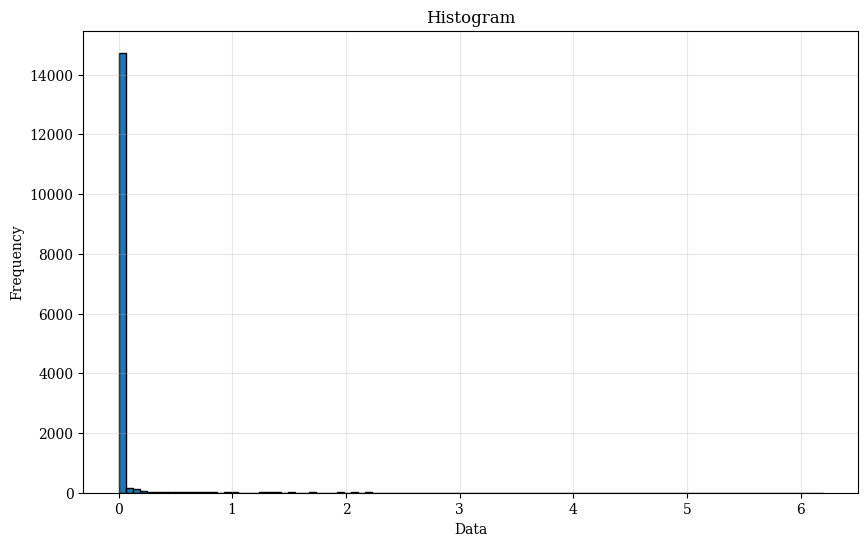

In [94]:
plot_histogram(refined_orbits_df['feature_distance_from_closest_orbit'], bins=100)

# Orbit Visualization

In [95]:
def filter_and_find_position(df, row_indexes, experiment_id_column):
    # Ensure row_indexes is a list
    if not isinstance(row_indexes, list):
        row_indexes = [row_indexes]
    
    positions = []
    experiment_ids = []
    
    for row_index in row_indexes:
        # Get the experiment_id value from the given row using iloc
        experiment_id = df.iloc[row_index][experiment_id_column]
        
        # Filter the DataFrame for rows with the same experiment_id
        filtered_df = df[df[experiment_id_column] == experiment_id]
        
        # Sort the filtered_df by 'id'
        sorted_df = filtered_df.sort_values(by='id_x')
        
        # Find the position of the initial row in the sorted DataFrame
        position = sorted_df.index.get_loc(df.index[row_index])
        
        positions.append(position)
        experiment_ids.append(int(experiment_id))
    
    return positions, experiment_ids

In [96]:
def find_closest_rows(df, column, value, n):
    # Calculate the absolute difference between the column values and the given value
    df['diff'] = (df[column] - value).abs()
    
    # Sort the DataFrame by the difference
    sorted_df = df.sort_values(by='diff')
    
    # Get the indexes of the n closest rows
    closest_indexes = sorted_df.head(n).index.tolist()
    
    # Drop the temporary 'diff' column
    df.drop(columns=['diff'], inplace=True)
    
    return closest_indexes

In [97]:
def visualize_orbit_and_closest_by_distance(df, column, value, n, experiment_id_column, orbits_folder, orbit_dataset):
    specific_orbits = []
    df.reset_index(drop=True, inplace=True)
    closest_rows = find_closest_rows(df, column, value, n)
    closest_indexes = df.loc[closest_rows].index.tolist()
    positions, experiment_ids = filter_and_find_position(df, closest_indexes, experiment_id_column)
    nearest_orbits = df.loc[closest_rows]['nearest_orbit'].tolist()
    
    for pos, exp_id, nearest_orbit in zip(positions, experiment_ids, nearest_orbits):
        orbits = np.load(f'{orbits_folder}/experiment_{exp_id}/exp{exp_id}_refined_orbits.npy')
        specific_orbit = orbits[pos:pos+1]
        specific_orbit, _, _ = reorder_orbits(specific_orbit)
        nearest_orbit_data = orbit_dataset[nearest_orbit:nearest_orbit+1]
        combined_orbits = np.vstack([specific_orbit, nearest_orbit_data])
        specific_orbits.append(combined_orbits)
    
    for orbits in specific_orbits:
        visualize_static_orbits(orbits[:,1:,:], orbit_names=['Synthetic Orbit', 'Closest Orbit in Training Dataset'],title=f'Physical Orbit Distance: {value}', equal_aspect=True)

    return specific_orbits

## Specific Distances

1

In [98]:
refined_orbits_df.head()

,id_x,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,disorder_metric,correct_order,inversions,kendall_tau_distance,propagated_position_error,propagated_velocity_error,propagated_energy_error,latent_distance_to_generation,calculated_jacobi,period_distance_with_generation,feature_closest_orbit,feature_distance_from_closest_orbit,nearest_orbit,nearest_orbit_distance,distance_from_generation,centroid_distance,feature_centroid_distance,closest_family_centroid,closest_family_centroid_distance,closest_family_feature_centroid,closest_family_feature_centroid_distance,initial_conditions_distance,closest_family_full_centroid,closest_family_full_centroid_distance,family_of_feature_closest_orbit,family_of_closest_orbit,experiment_id,id_y,discarded_family_ids,is_discovered
0,0,2.825363,3.395283,9,2.866915e-13,1.085847,0.005968,-0.006422,0.007797,0.193831,-0.008355,1.131194,-0.024008,2.689891e-16,-0.007002,0.117360,-2.899136e-15,372.0,66.0,255.0,0.103030,1.329037e-12,2.465352e-12,1.481195e-14,0.116331,3.173176,0.569921,17972,0.000104,17976,0.409855,1.208203,0.830977,3.933960,22,0.166260,6,0.645355,0.095566,6,0.121419,15.0,15.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",no
1,3,6.410875,6.306637,9,3.831047e-10,1.077167,0.244604,0.427690,0.050803,-1.548356,0.846692,0.774984,0.387647,4.910636e-01,0.073323,-1.206546,8.439762e-01,150.0,69.0,98.0,0.039596,6.852558e-12,1.434101e-11,2.466171e-11,0.239348,0.591147,0.104238,30631,0.000694,27453,3.967637,4.725327,2.500625,2.045136,18,0.486709,15,0.159043,0.482846,23,0.482840,29.0,25.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",no
2,5,2.774760,3.382448,8,1.560247e-13,1.078207,0.011581,0.003735,0.007048,0.144430,-0.018307,1.140318,-0.014000,-7.494117e-14,-0.005923,0.077325,1.243685e-13,276.0,64.0,187.0,0.075556,1.162738e-12,2.025713e-12,3.925031e-15,0.140431,3.179420,0.607688,17992,0.000240,17992,0.169285,1.082909,0.824064,3.947770,22,0.173278,6,0.659336,0.097635,6,0.114895,15.0,15.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",no
3,11,22.927443,22.944445,9,6.897051e-12,1.048586,0.020412,-0.036356,0.013088,0.715763,-0.018567,0.906908,0.048871,-1.470502e-02,0.185644,0.562421,2.131846e-02,4.0,98.0,2.0,0.000808,7.630890e-12,1.316706e-11,2.564077e-12,0.045951,2.885993,0.017003,42943,0.003184,42922,2.087514,2.232660,1.988188,15.698535,32,0.302875,37,1.264695,0.276101,37,0.300966,40.0,40.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",no
4,14,6.659652,5.645048,6,3.873477e-12,0.787035,-0.122416,0.049502,0.276159,0.940814,-0.412493,0.642761,-0.185012,1.920668e-02,0.314235,0.605758,-3.829873e-01,68.0,78.0,36.0,0.014545,1.742954e-12,3.321685e-12,1.132078e-12,0.263792,2.810963,1.014603,28414,0.000941,28420,0.970354,2.066139,0.323756,1.658958,19,0.222946,14,0.327624,0.374478,24,0.221195,26.0,26.0,54,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",no


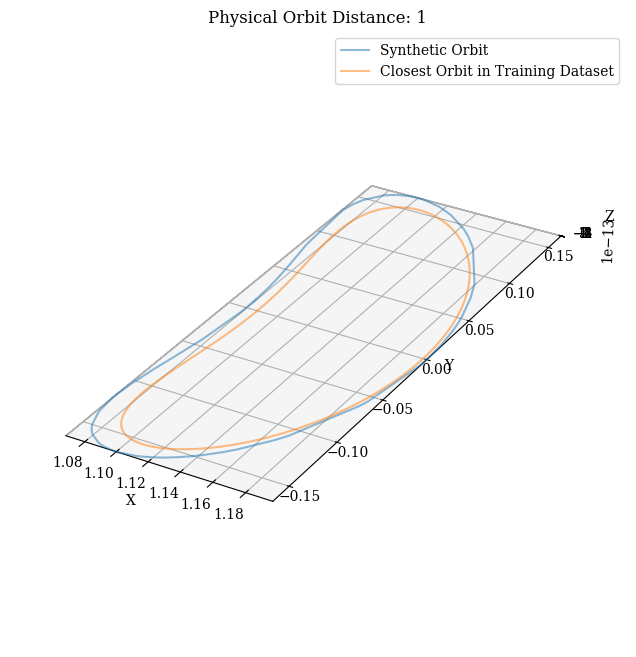

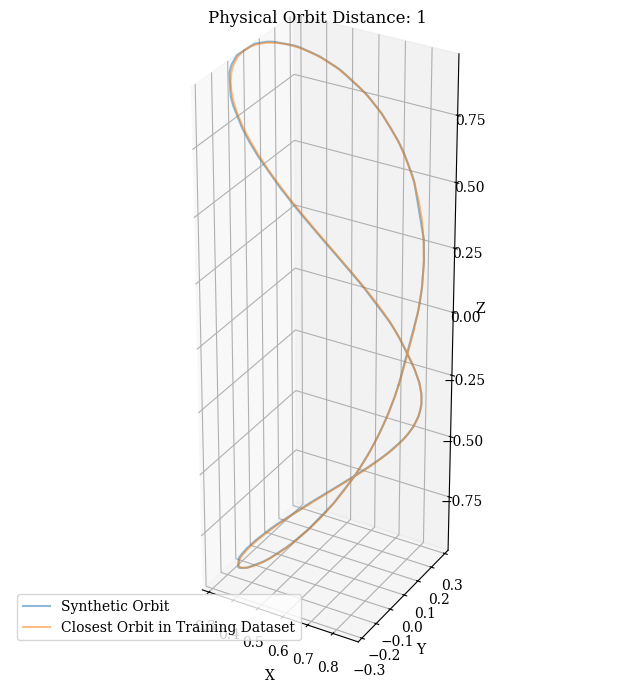

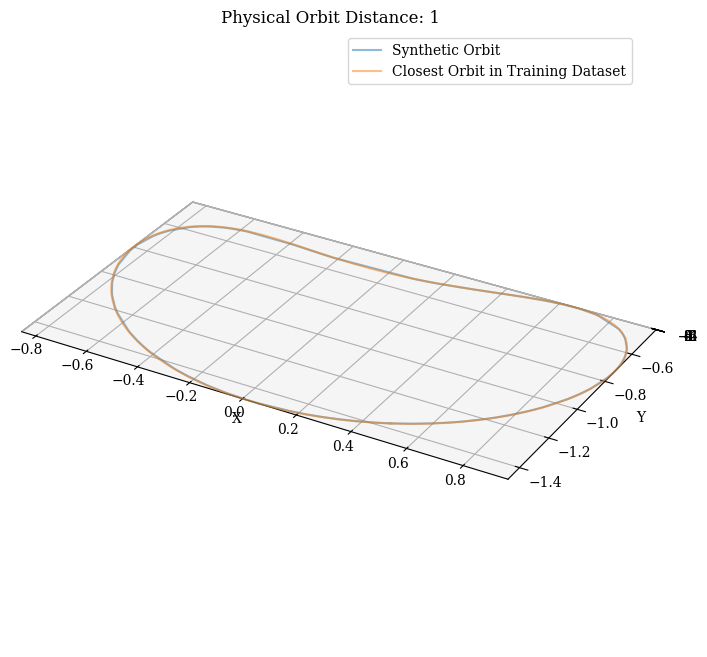

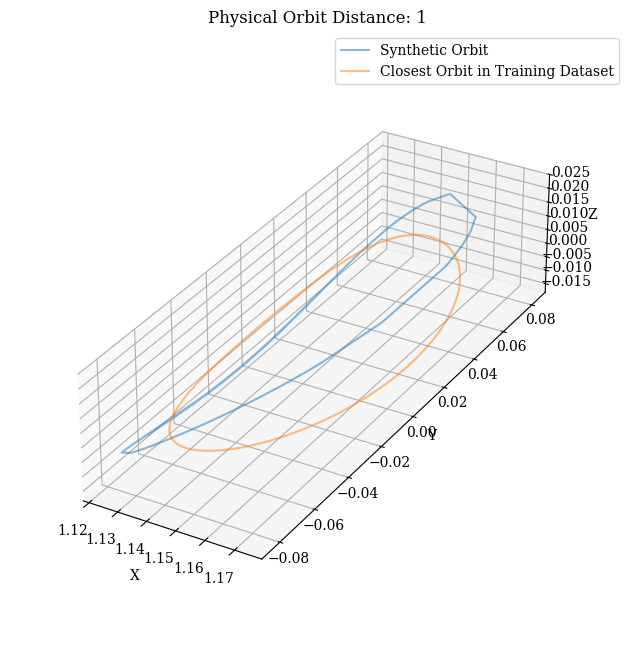

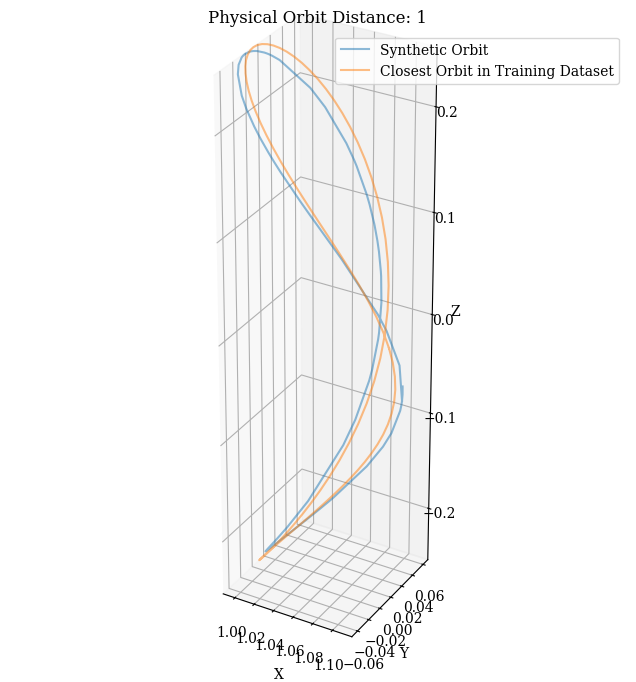

In [99]:
specific_orbits = visualize_orbit_and_closest_by_distance(refined_orbits_df, 'nearest_orbit_distance', 1, 5, 'experiment_id', experiments_folder, data)

2.5

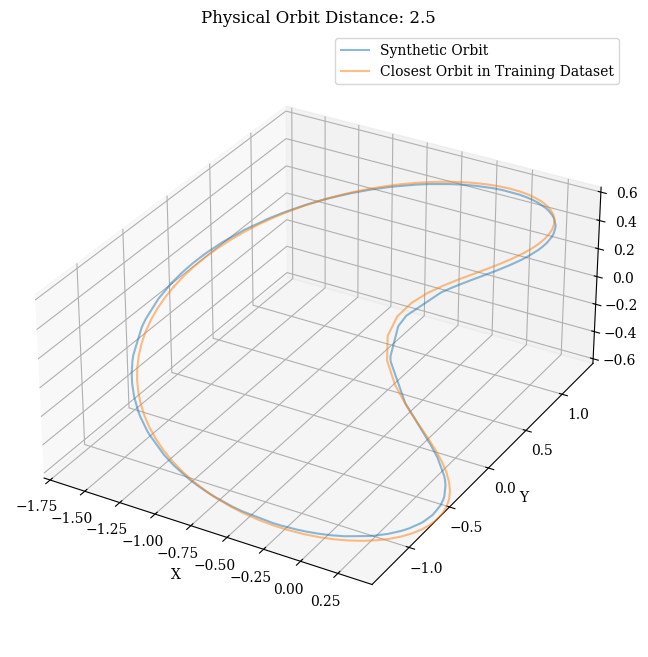

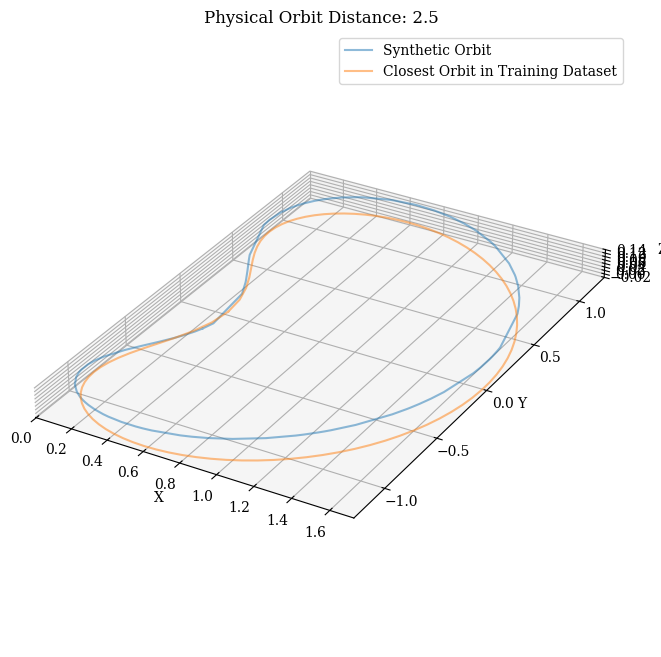

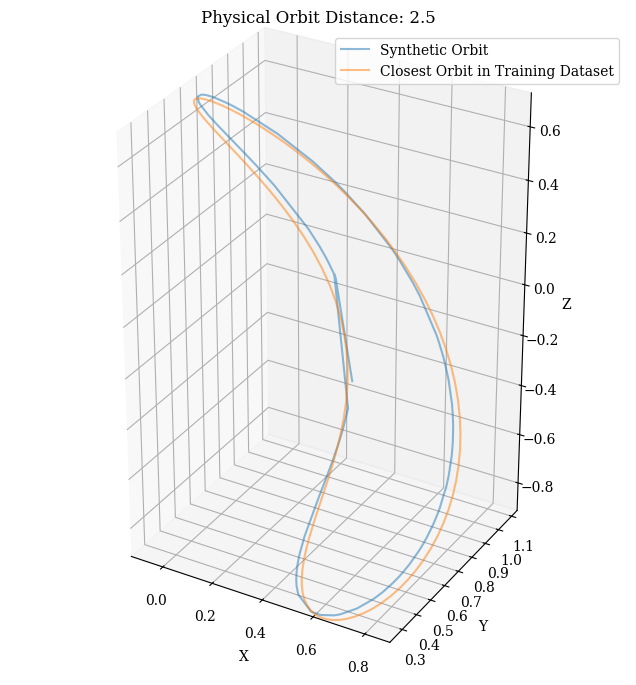

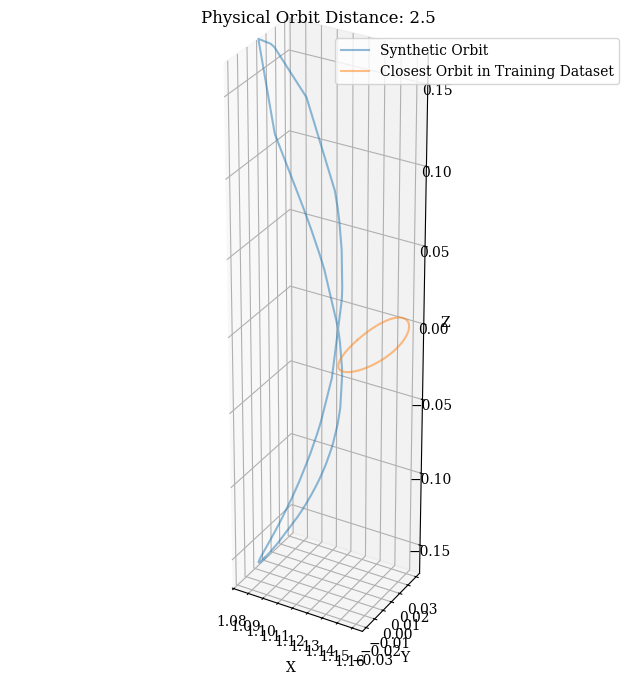

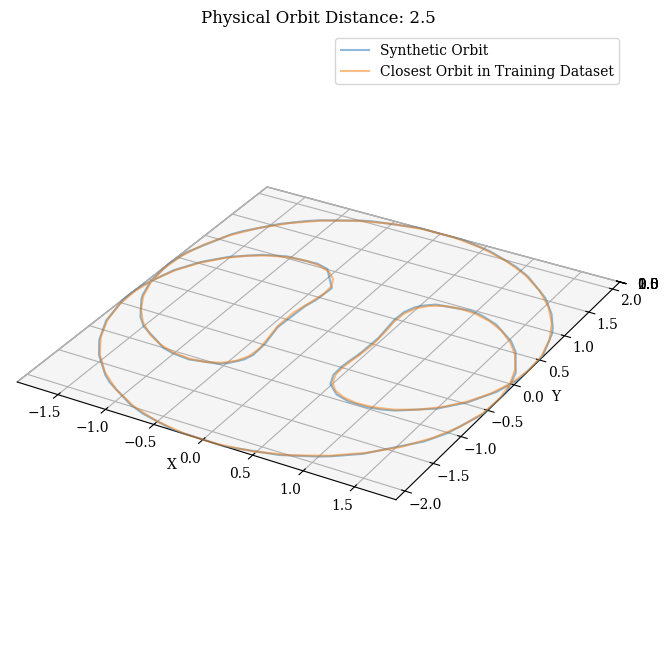

In [100]:
specific_orbits = visualize_orbit_and_closest_by_distance(refined_orbits_df, 'nearest_orbit_distance', 2.5, 5, 'experiment_id', experiments_folder, data)

5

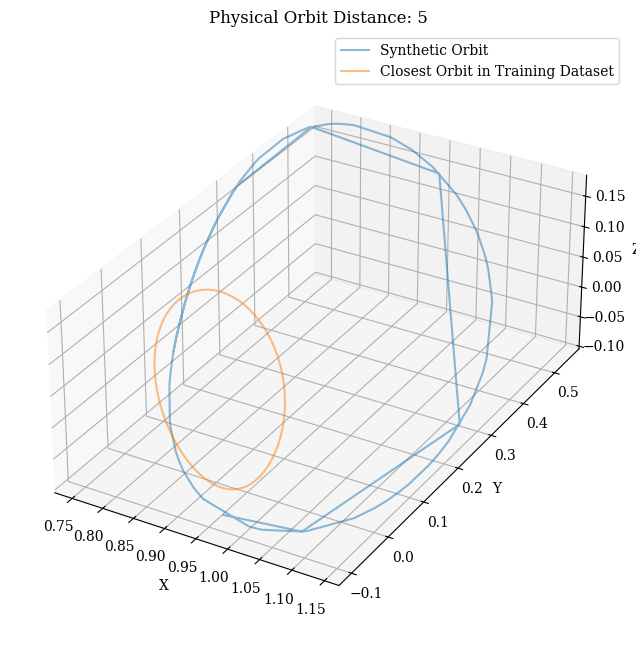

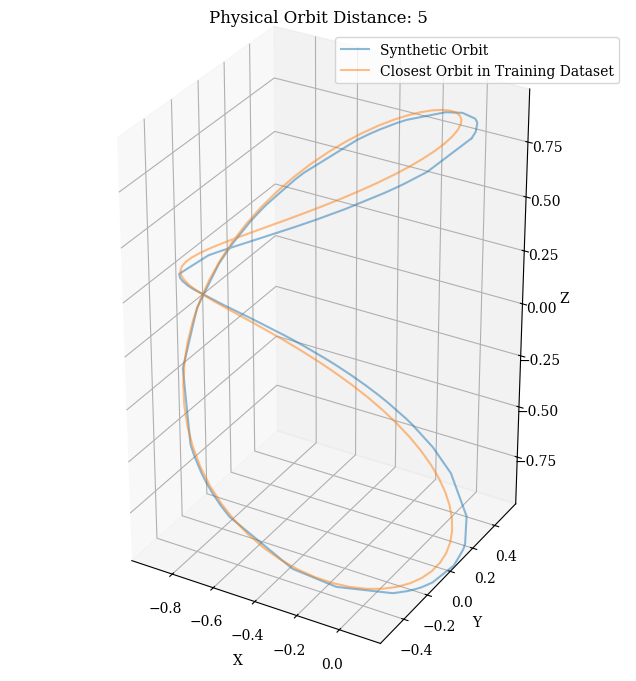

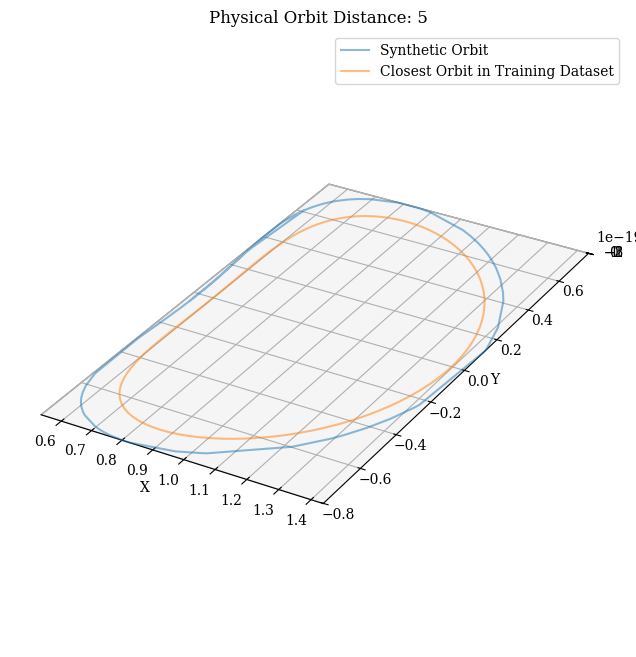

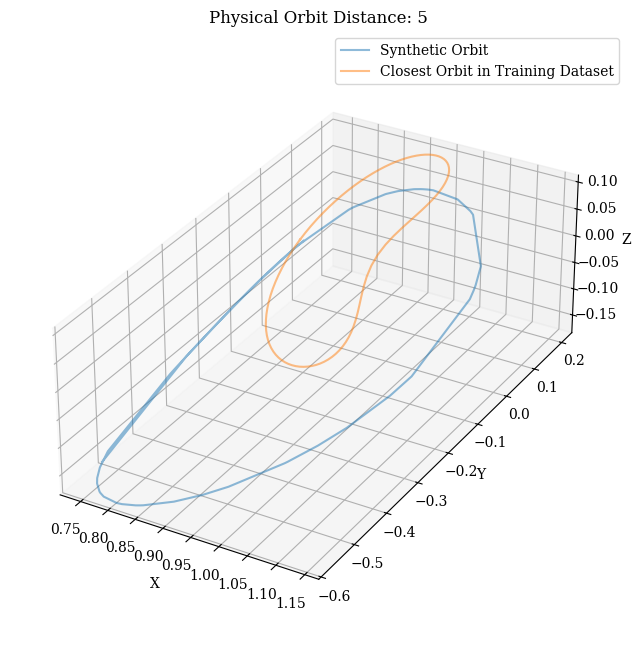

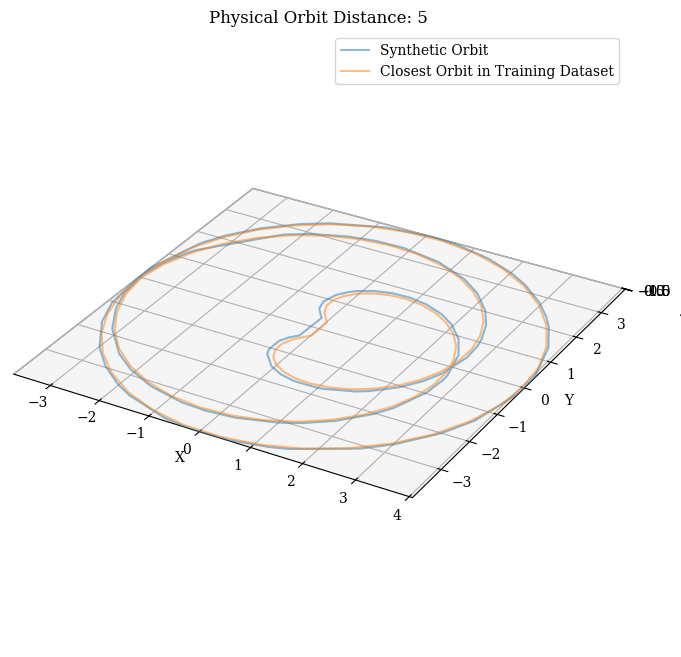

In [101]:
specific_orbits = visualize_orbit_and_closest_by_distance(refined_orbits_df, 'nearest_orbit_distance', 5, 5, 'experiment_id', experiments_folder, data)

10

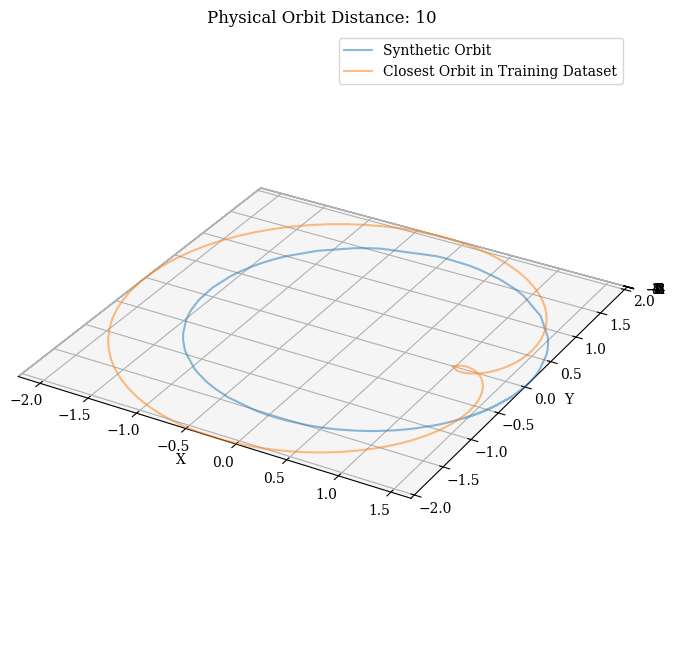

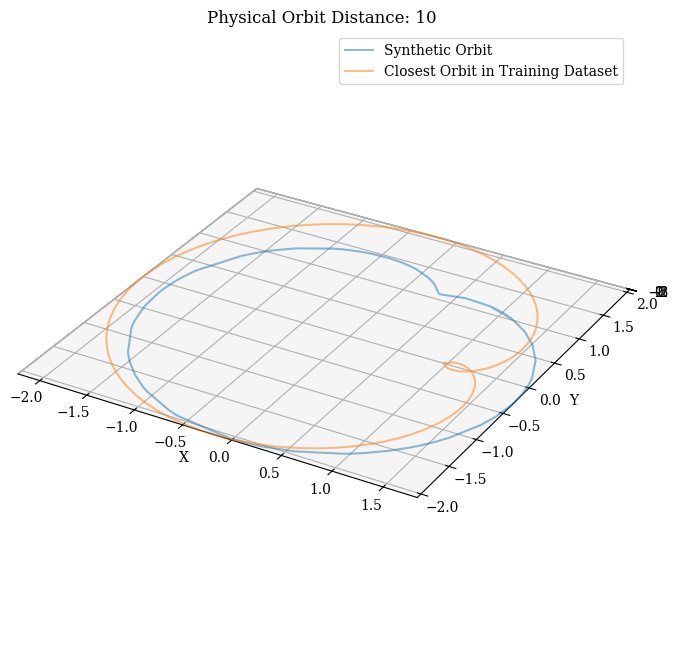

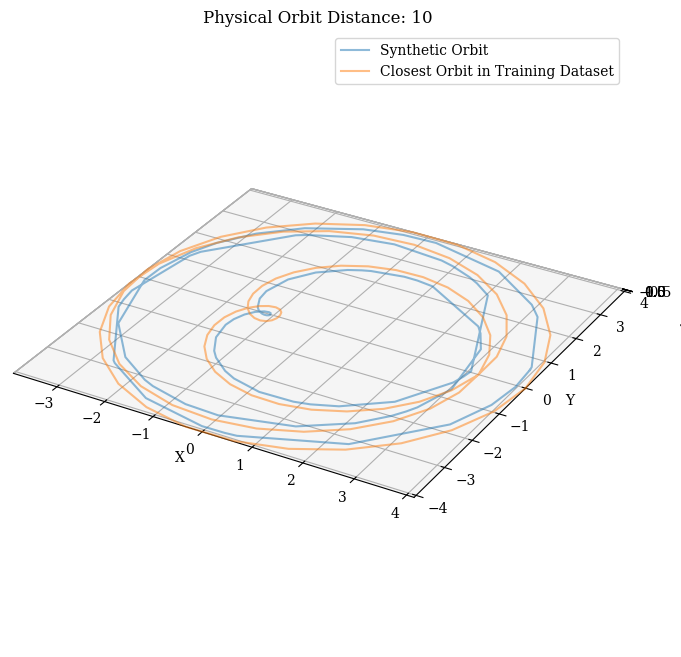

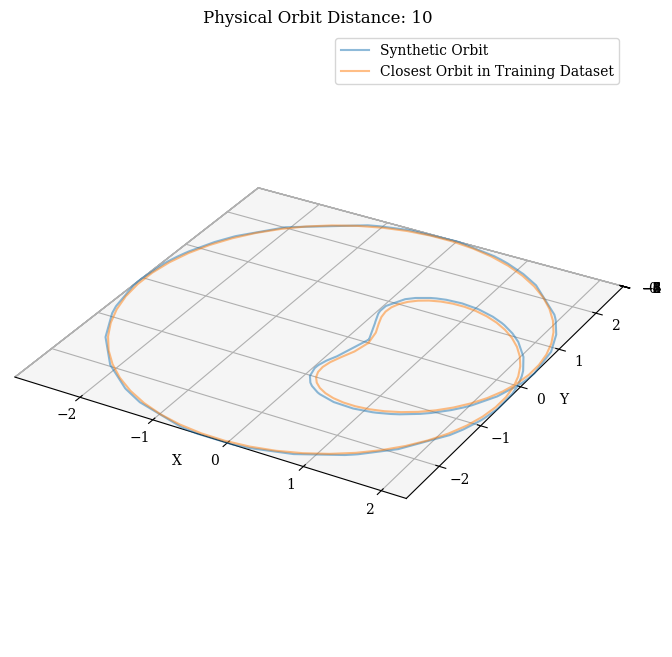

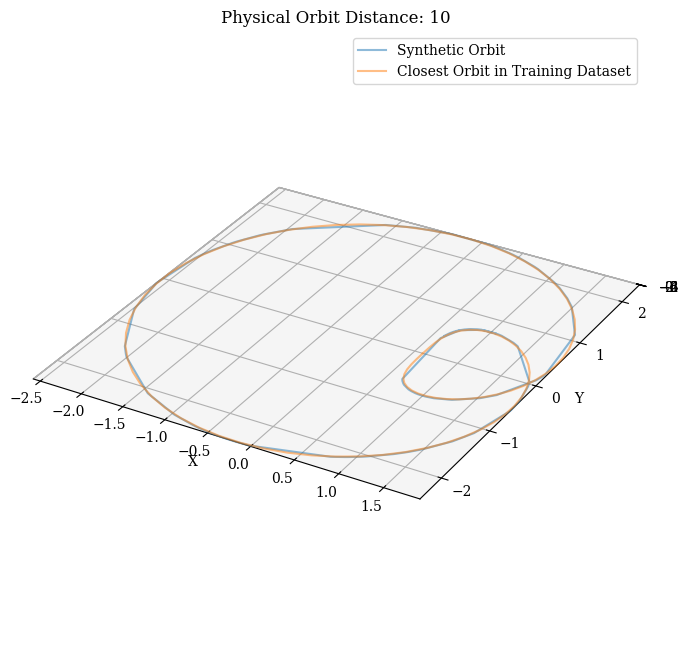

In [102]:
specific_orbits = visualize_orbit_and_closest_by_distance(refined_orbits_df, 'nearest_orbit_distance', 10, 5, 'experiment_id', experiments_folder, data)

20

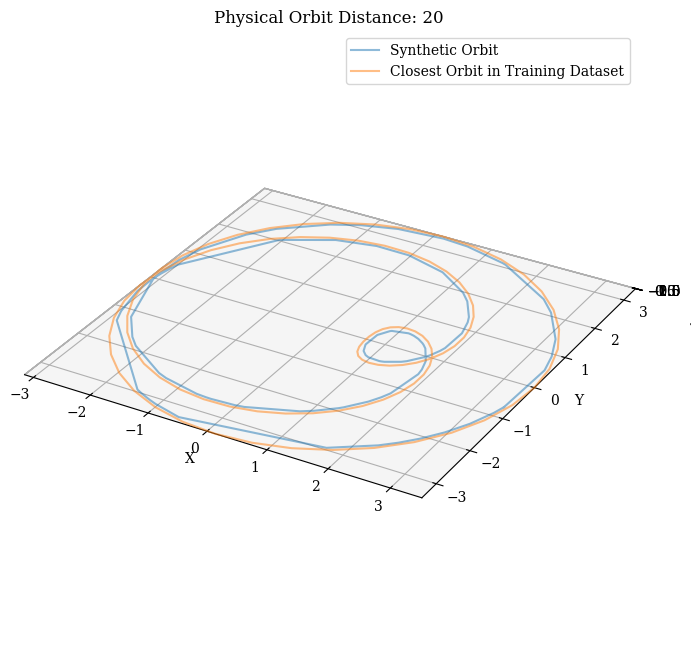

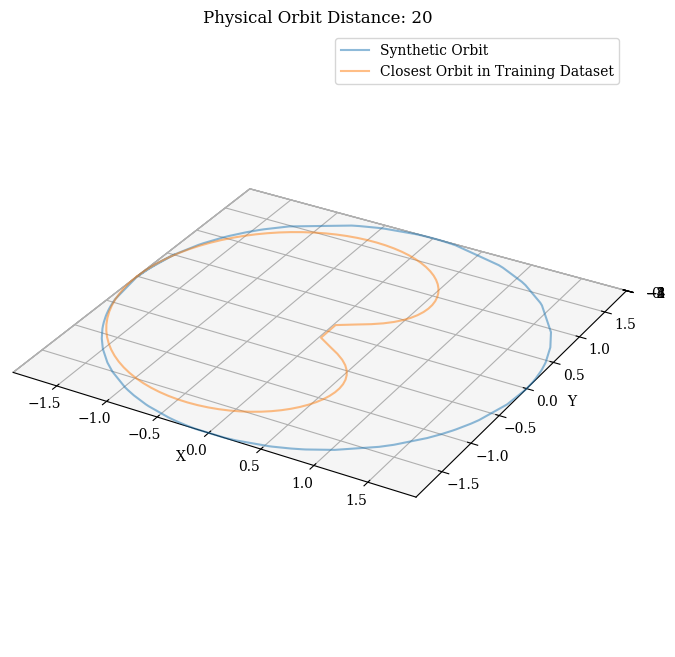

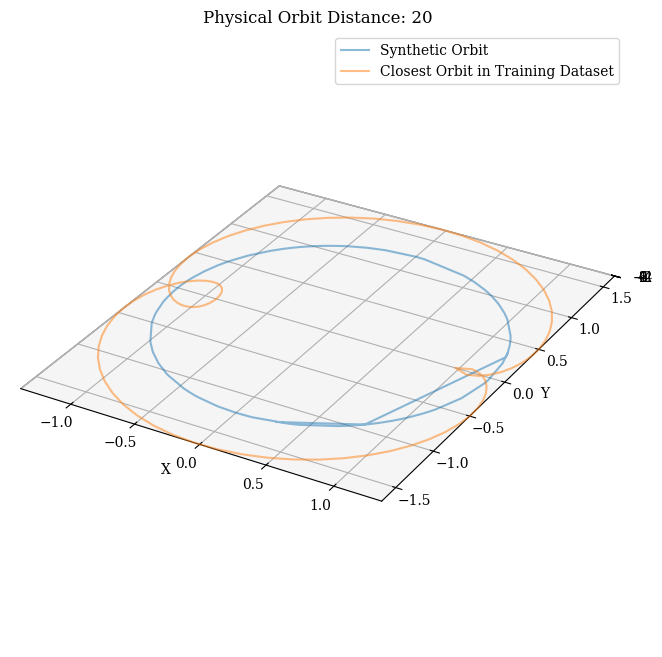

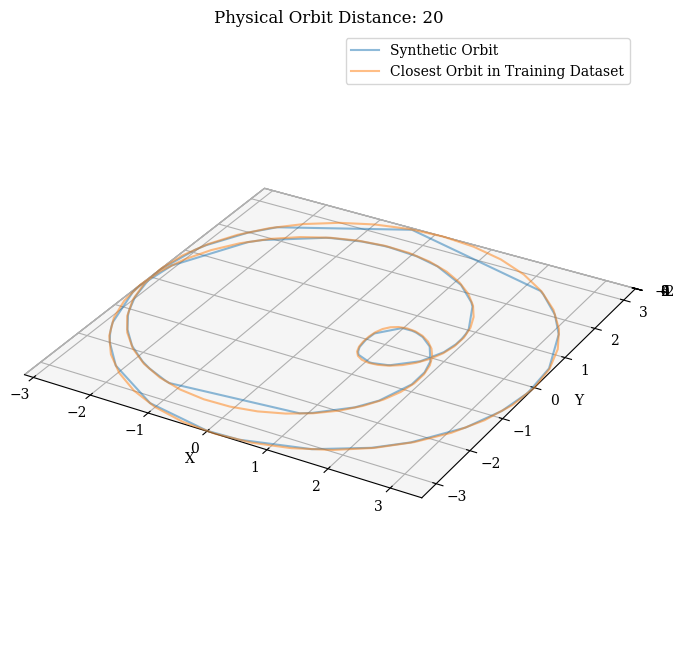

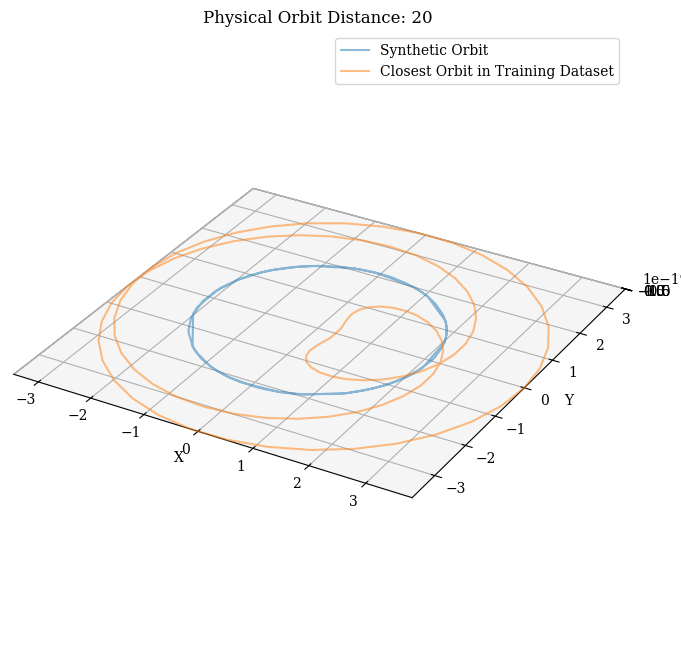

In [103]:
specific_orbits = visualize_orbit_and_closest_by_distance(refined_orbits_df, 'nearest_orbit_distance', 20, 5, 'experiment_id', experiments_folder, data)

30

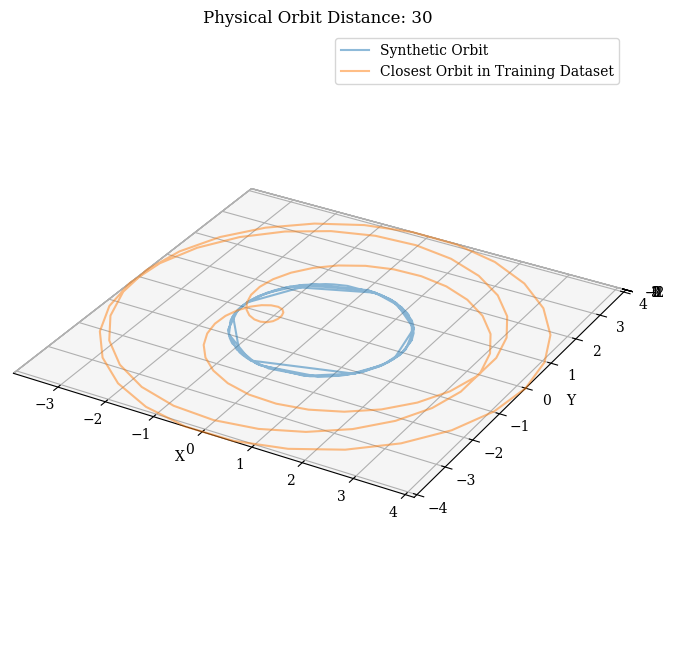

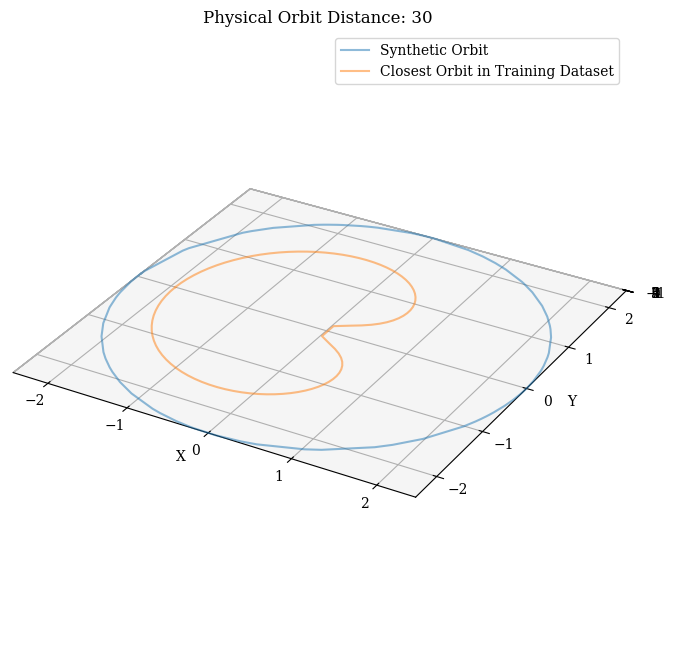

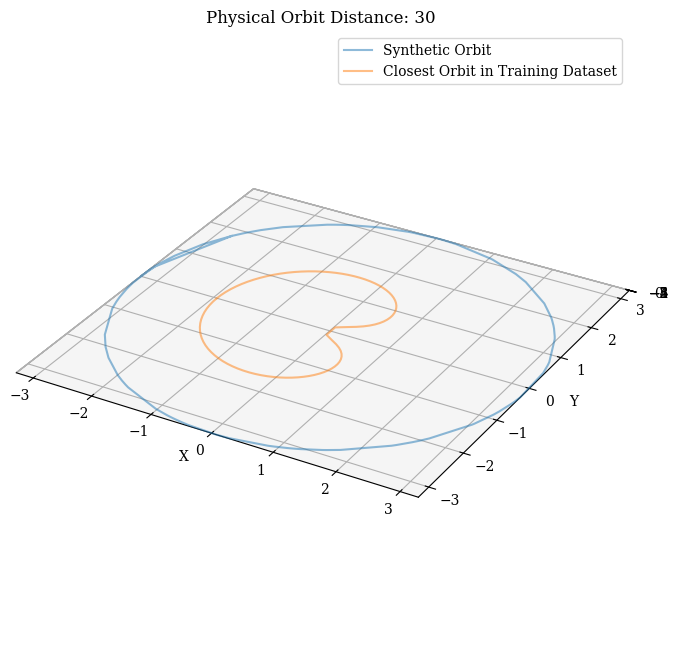

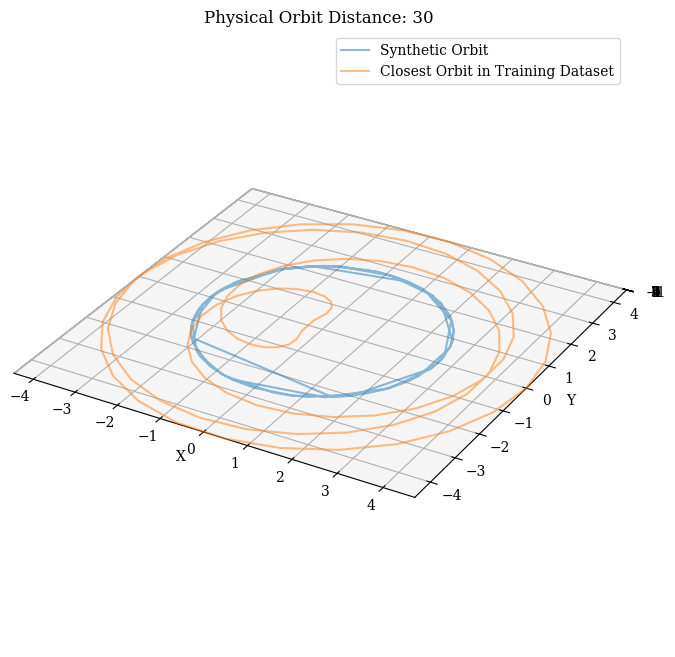

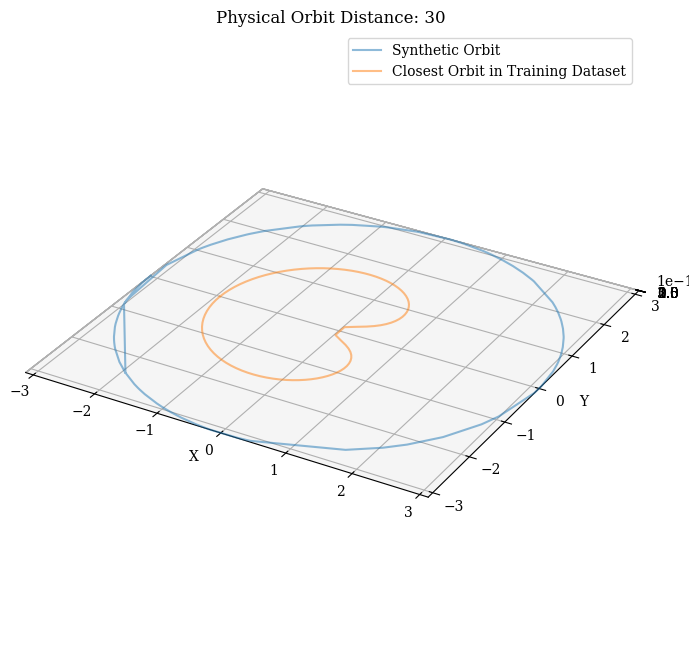

In [104]:
specific_orbits = visualize_orbit_and_closest_by_distance(refined_orbits_df, 'nearest_orbit_distance', 30, 5, 'experiment_id', experiments_folder, data)

## Rnadom Orbits

In [105]:
def visualize_orbit_and_closest_by_distance(df, column, value, n, experiment_id_column, orbits_folder, orbit_dataset):
    specific_orbits = []
    df.reset_index(drop=True, inplace=True)
    closest_rows = find_closest_rows(df, column, value, n)
    closest_indexes = df.loc[closest_rows].index.tolist()
    positions, experiment_ids = filter_and_find_position(df, closest_indexes, experiment_id_column)
    nearest_orbits = df.loc[closest_rows]['nearest_orbit'].tolist()
    
    for pos, exp_id, nearest_orbit in zip(positions, experiment_ids, nearest_orbits):
        orbits = np.load(f'{orbits_folder}/experiment_{exp_id}/exp{exp_id}_refined_orbits.npy')
        specific_orbit = orbits[pos:pos+1]
        specific_orbit, _, _ = reorder_orbits(specific_orbit)
        nearest_orbit_data = orbit_dataset[nearest_orbit:nearest_orbit+1]
        combined_orbits = np.vstack([specific_orbit, nearest_orbit_data])
        specific_orbits.append(combined_orbits)
    
    for orbits in specific_orbits:
        visualize_static_orbits(orbits[:,1:,:], orbit_names=['Synthetic Orbit', 'Closest Orbit in Training Dataset'],title=f'Physical Orbit Distance: {value}', equal_aspect=True)

    return specific_orbits

## Other

In [106]:
#| export
#| hide
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import seaborn as sns
import os
from scipy import stats
from typing import Optional, List, Dict, Union, Any

#| export
def plot_2d_latent_space(
    latent_representations: np.ndarray,
    labels: np.ndarray,
    latent_stdevs: Optional[np.ndarray] = None,
    features: Optional[Any] = None,
    feature_names: Optional[List[str]] = None,
    figsize: tuple = (12, 12),
    save_path: Optional[str] = None,
    many_classes: bool = False,
    show_legend: bool = True,
    legend_fontsize: int = 8,
    plot_std: bool = True,
    title: Optional[str] = '2D Latent Space Visualization',  # New title parameter
    title_size: int = 14,  # New title_size parameter
    axis_labels: Optional[Tuple[str, str]] = ('Dimension 1', 'Dimension 2'),  # New axis_labels parameter
    normalize_data: bool = True,  # New parameter to control normalization
    **kwargs: Any
) -> None:
    """
    Plots a 2D latent space visualization with class labels and feature distributions.

    Parameters:
    - latent_representations: np.ndarray, shape (n_samples, 2)
        The 2D coordinates of the latent representations.
    - labels: np.ndarray, shape (n_samples,)
        The class labels for each sample.
    - features: Optional[Any], shape (n_samples, n_features)
        The feature data to plot distributions. Can be a list or a NumPy array.
    - feature_names: Optional[List[str]]
        The names of the features.
    - figsize: tuple, default (12, 12)
        The size of the entire figure.
    - save_path: Optional[str]
        Path to save the figure. If None, the plot is not saved.
    - many_classes: bool, default False
        If True, uses different markers for classes.
    - show_legend: bool, default True
        If True, displays legends.
    - legend_fontsize: int, default 8
        Font size for the legends.
    - plot_std: bool, default True
        If True, plots the standard deviation shading for feature distributions.
    - title: Optional[str], default '2D Latent Space Visualization'
        Title of the plot.
    - title_size: int, default 14
        Font size for the title.
    - axis_labels: Optional[Tuple[str, str]], default ('Dimension 1', 'Dimension 2')
        Labels for the X and Y axes.
    - normalize_data: bool, default False
        If True, normalizes the latent representations.
    - kwargs: Any
        Additional keyword arguments passed to scatter plots.
    """
    # Normalize latent representations if requested
    if normalize_data:
        latent_representations = (latent_representations - np.mean(latent_representations, axis=0)) / np.std(latent_representations, axis=0)

    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    class_names = label_encoder.classes_

    # Colormap and markers for classes
    cmap_classes = plt.get_cmap('tab20', len(class_names))
    markers = ['o', 's', '^', 'v', 'D', '<', '>', 'p', '*', 'h', 'H', '8']

    # Define fixed colors for features
    predefined_feature_colors = ['orange', 'purple', 'green']
    if feature_names and len(feature_names) > len(predefined_feature_colors):
        # Cycle through the predefined colors if more features are present
        feature_colors = predefined_feature_colors * (len(feature_names) // len(predefined_feature_colors) + 1)
    else:
        feature_colors = predefined_feature_colors[:len(feature_names)] if feature_names else []

    # Create figure and GridSpec
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[5, 1], wspace=0.3, hspace=0.3)

    ax_main = fig.add_subplot(gs[0, 0])

    # Plot latent representations with optional error bars for standard deviation
    if many_classes:
        for class_idx, class_name in enumerate(class_names):
            class_mask = (encoded_labels == class_idx)
            color = cmap_classes(class_idx % cmap_classes.N)
            ax_main.scatter(
                latent_representations[class_mask, 0],
                latent_representations[class_mask, 1],
                label=class_name,
                color=color,
                s=30,
                **kwargs
            )
            if latent_stdevs is not None:
                ax_main.errorbar(
                    latent_representations[class_mask, 0],
                    latent_representations[class_mask, 1],
                    xerr=latent_stdevs[class_mask, 0],
                    yerr=latent_stdevs[class_mask, 1],
                    fmt='none',
                    ecolor=color,
                    alpha=0.5
                )
                
    else:
        unique_labels = np.unique(encoded_labels)
        for class_idx in unique_labels:
            class_name = class_names[class_idx]
            class_mask = (encoded_labels == class_idx)
            color = cmap_classes(class_idx % cmap_classes.N)
            ax_main.scatter(
                latent_representations[class_mask, 0],
                latent_representations[class_mask, 1],
                label=class_name,
                color=color,
                s=30,
                **kwargs
            )
            if latent_stdevs is not None:
                ax_main.errorbar(
                    latent_representations[class_mask, 0],
                    latent_representations[class_mask, 1],
                    xerr=latent_stdevs[class_mask, 0],
                    yerr=latent_stdevs[class_mask, 1],
                    fmt='none',
                    ecolor=color,
                    alpha=0.5
                )

    if show_legend:
        ax_main.legend(title="Classes", fontsize=legend_fontsize)

    if title is not None:
        ax_main.set_title(title, fontsize=title_size)  # Use the title parameter and title_size
    
    if axis_labels is not None:
        ax_main.set_xlabel(axis_labels[0], fontsize=13)  # Increased fontsize for axis labels
        ax_main.set_ylabel(axis_labels[1], fontsize=13)  # Increased fontsize for axis labels

    # Set aspect ratio to be adjustable
    ax_main.set_aspect('auto')

    # Get data limits
    x_min, x_max = latent_representations[:, 0].min(), latent_representations[:, 0].max()
    y_min, y_max = latent_representations[:, 1].min(), latent_representations[:, 1].max()
    
    # Set limits to fit the figsize with added space
    x_margin = (x_max - x_min) * 0.1  # 10% margin
    y_margin_top = (y_max - y_min) * 0.1  # 10% margin
    y_margin_bottom = (y_max - y_min) * 0.42  # 20% margin for bottom
    ax_main.set_xlim(x_min - x_margin, x_max + x_margin)
    ax_main.set_ylim(y_min - y_margin_bottom, y_max + y_margin_top)

    # Plot feature distributions with standard deviation if features are provided and plot_std is True
    if features is not None and feature_names is not None:
        # Convert features to NumPy array if it's a list
        if isinstance(features, list):
            features = np.array(features)

        ax_hist_x = fig.add_subplot(gs[1, 0], sharex=ax_main)
        ax_hist_y = fig.add_subplot(gs[0, 1], sharey=ax_main)

        x_bins = np.linspace(x_min, x_max, 100)
        y_bins = np.linspace(y_min, y_max, 100)

        # Initialize lists to store legend handles for features
        feature_legend_elements = []

        for feature_index, feature_name in enumerate(feature_names):
            # Assign a specific color to each feature
            if feature_index < len(feature_colors):
                color = feature_colors[feature_index]
            else:
                color = 'gray'  # Default color if predefined colors are exhausted

            ### Plotting for x-axis
            # Compute mean and std for x-axis
            avg_feature_norm_x = [
                features[(latent_representations[:, 0] >= x_bins[i]) & (latent_representations[:, 0] < x_bins[i+1]), feature_index].mean()
                if np.any((latent_representations[:, 0] >= x_bins[i]) & (latent_representations[:, 0] < x_bins[i+1]))
                else np.nan
                for i in range(len(x_bins)-1)
            ]
            std_feature_norm_x = [
                features[(latent_representations[:, 0] >= x_bins[i]) & (latent_representations[:, 0] < x_bins[i+1]), feature_index].std()
                if np.any((latent_representations[:, 0] >= x_bins[i]) & (latent_representations[:, 0] < x_bins[i+1]))
                else np.nan
                for i in range(len(x_bins)-1)
            ]

            # Convert to NumPy arrays for easier handling
            avg_feature_norm_x = np.array(avg_feature_norm_x)
            std_feature_norm_x = np.array(std_feature_norm_x)

            # Handle NaNs
            if plot_std:
                valid_x = ~np.isnan(avg_feature_norm_x) & ~np.isnan(std_feature_norm_x)
            else:
                valid_x = ~np.isnan(avg_feature_norm_x)

            if np.any(valid_x):
                avg_x = avg_feature_norm_x[valid_x]
                bin_centers_x = (x_bins[:-1] + x_bins[1:]) / 2
                bin_centers_x = bin_centers_x[valid_x]

                # Normalize mean
                avg_min_x, avg_max_x = avg_x.min(), avg_x.max()
                ptp_x = avg_max_x - avg_min_x
                avg_norm_x = (avg_x - avg_min_x) / (ptp_x + 1e-8)

                if plot_std:
                    # Normalize std
                    std_x = std_feature_norm_x[valid_x]
                    std_min_x, std_max_x = std_x.min(), std_x.max()
                    ptp_std_x = std_max_x - std_min_x
                    if ptp_std_x > 0:
                        std_norm_x = (std_x - std_min_x) / (ptp_std_x + 1e-8)
                    else:
                        std_norm_x = np.zeros_like(std_x)

                # Plot mean line
                line_mean_x, = ax_hist_x.plot(
                    bin_centers_x,
                    avg_norm_x,
                    color=color,
                    label=f'{feature_name} Mean'
                )

                if plot_std:
                    # Plot std deviation shaded area
                    ax_hist_x.fill_between(
                        bin_centers_x,
                        avg_norm_x - std_norm_x,
                        avg_norm_x + std_norm_x,
                        color=mcolors.to_rgba(color, alpha=0.3),
                        label=f'{feature_name} Std'
                    )

                # Collect legend handles
                feature_legend_elements.append(Line2D([0], [0], color=color, lw=2, label=f'{feature_name} Mean'))
                if plot_std:
                    feature_legend_elements.append(Patch(facecolor=mcolors.to_rgba(color, alpha=0.3), edgecolor='none', label=f'{feature_name} Std'))

            ### Plotting for y-axis
            # Compute mean and std for y-axis
            avg_feature_norm_y = [
                features[(latent_representations[:, 1] >= y_bins[i]) & (latent_representations[:, 1] < y_bins[i+1]), feature_index].mean()
                if np.any((latent_representations[:, 1] >= y_bins[i]) & (latent_representations[:, 1] < y_bins[i+1]))
                else np.nan
                for i in range(len(y_bins)-1)
            ]
            std_feature_norm_y = [
                features[(latent_representations[:, 1] >= y_bins[i]) & (latent_representations[:, 1] < y_bins[i+1]), feature_index].std()
                if np.any((latent_representations[:, 1] >= y_bins[i]) & (latent_representations[:, 1] < y_bins[i+1]))
                else np.nan
                for i in range(len(y_bins)-1)
            ]

            # Convert to NumPy arrays for easier handling
            avg_feature_norm_y = np.array(avg_feature_norm_y)
            std_feature_norm_y = np.array(std_feature_norm_y)

            # Handle NaNs
            if plot_std:
                valid_y = ~np.isnan(avg_feature_norm_y) & ~np.isnan(std_feature_norm_y)
            else:
                valid_y = ~np.isnan(avg_feature_norm_y)

            if np.any(valid_y):
                avg_y = avg_feature_norm_y[valid_y]
                bin_centers_y = (y_bins[:-1] + y_bins[1:]) / 2
                bin_centers_y = bin_centers_y[valid_y]

                # Normalize mean
                avg_min_y, avg_max_y = avg_y.min(), avg_y.max()
                ptp_y = avg_max_y - avg_min_y
                avg_norm_y = (avg_y - avg_min_y) / (ptp_y + 1e-8)

                if plot_std:
                    # Normalize std
                    std_y = std_feature_norm_y[valid_y]
                    std_min_y, std_max_y = std_y.min(), std_y.max()
                    ptp_std_y = std_max_y - std_min_y
                    if ptp_std_y > 0:
                        std_norm_y = (std_y - std_min_y) / (ptp_std_y + 1e-8)
                    else:
                        std_norm_y = np.zeros_like(std_y)

                # Plot mean line
                line_mean_y, = ax_hist_y.plot(
                    avg_norm_y,
                    bin_centers_y,
                    color=color,
                    label=f'{feature_name} Mean'
                )

                if plot_std:
                    # Plot std deviation shaded area
                    ax_hist_y.fill_betweenx(
                        bin_centers_y,
                        avg_norm_y - std_norm_y,
                        avg_norm_y + std_norm_y,
                        color=mcolors.to_rgba(color, alpha=0.3),
                        label=f'{feature_name} Std'
                    )

                # Collect legend handles
                # Note: Avoid duplicating legend entries; already added during x-axis plotting

        # Create separate legends
        handles_main = []
        if show_legend:
            handles_main, labels_main = ax_main.get_legend_handles_labels()
        
        handles_feature = []
        labels_feature = []
        if features is not None and feature_names is not None and show_legend:
            handles_feature = feature_legend_elements
            labels_feature = [elem.get_label() for elem in feature_legend_elements]
        
        # Add feature legend separately
        if handles_feature and labels_feature:
            # Position the feature legend outside the main plot
            ax_main.legend(
                handles=handles_main,
                labels=labels_main,
                title="Classes",
                fontsize=legend_fontsize,
                loc='upper left'
            )
            ax_hist_x.legend(
                handles=handles_feature,
                labels=labels_feature,
                title="Features",
                fontsize=legend_fontsize,
                loc='upper right'
            )
        elif handles_main and labels_main:
            # Only main legend
            ax_main.legend(title="Classes", fontsize=legend_fontsize, loc='best')

        # Set titles and labels for histograms
        if features is not None and feature_names is not None:
            ax_hist_x.set_title('Normalized Horizontal Feature Distributions')
            ax_hist_x.set_xlabel('Dimension 1', fontsize=12)  # Increased fontsize for axis labels
            ax_hist_y.set_title('Normalized Vertical Feature Distributions')
            ax_hist_y.set_ylabel('Dimension 2', fontsize=12)  # Increased fontsize for axis labels

            # Hide tick labels on shared axes to avoid clutter
            plt.setp(ax_hist_x.get_xticklabels(), visible=False)
            plt.setp(ax_hist_y.get_yticklabels(), visible=False)

        # Save the plot if save_path is provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Saved plot to {save_path}")

        plt.show()

NameError: name 'Tuple' is not defined